In [336]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [337]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import sklearn

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 데이터 불러오기

In [338]:
train = pd.read_csv("/content/drive/MyDrive/전력사용량예측/train.csv",encoding='cp949')
building_info = pd.read_csv("/content/drive/MyDrive/전력사용량예측/building_info.csv",encoding='cp949')

In [339]:
train

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


In [340]:
train.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [341]:
building_info.head()

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


# 변수명 영어로 변환

In [342]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
#의미없는 변수 제거
train.drop('num_date_time', axis = 1, inplace=True)

In [343]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [344]:
building_info.head()

,building_number,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000


In [345]:


translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

# 결측치 확인

In [346]:
train.isna().sum()

building_number           0
date_time                 0
temperature               0
rainfall             160069
windspeed                19
humidity                  9
sunshine              75182
solar_radiation       87913
power_consumption         0
dtype: int64

5개 변수에 대해 결측치존재.


rainfall(강수량)의 결측치는 결측이 아닌 비가 오지 않은 날을 의미. 0으로 변환

In [347]:
train['rainfall']= train['rainfall'].fillna(0)

sunshine(일조)과 solar_radiation(일사)는 결측 비율이 매우높으므로 변수 자체를 제거(열제거)하기로 결정

In [348]:
train = train.drop(columns=['sunshine', 'solar_radiation'])

humidity(습도),windspeed(풍속) 결측치 비율이 낮음. eda상에서 skewed되어있으므로 중앙값으로 변환

In [349]:
train['humidity'].fillna(round(train['humidity'].median(),2), inplace=True)
train['windspeed'].fillna(round(train['windspeed'].median(),2), inplace=True)


In [350]:
train.isna().sum() # 결측치 모두 처리한 결과

building_number      0
date_time            0
temperature          0
rainfall             0
windspeed            0
humidity             0
power_consumption    0
dtype: int64

building_info 결측치 탐색

In [351]:
building_info.shape

(100, 7)

In [352]:
print(len(building_info[building_info['solar_power_capacity'] == '-']))
print(len(building_info[building_info['ess_capacity'] == '-']))
print(len(building_info[building_info['pcs_capacity'] == '-']))

64
95
95


결측치 비율이 매우 높으므로 '-'표시는 결측치가 아닌 태양광 장치가 없는 건물을 '-'로 표현했을거라는 추측. 따라서 '-' 0으로 변환

In [353]:
cols = ['solar_power_capacity','ess_capacity','pcs_capacity']

In [354]:
for col in cols :
    building_info[col] = building_info[col].apply(lambda x : 0 if x =='-' else float(x))

# test랑 building_info 합치기

In [355]:
train = pd.merge(train, building_info, on='building_number', how='left')

# 시계열 특성을 학습에 반영하기 위해 datetime을 년,월,일,시간으로 쪼개기

In [356]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['year'] = train['date_time'].dt.year

In [357]:
train.tail()

,building_number,date_time,temperature,rainfall,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity,hour,day,month,year
203995,100,2022-08-24 19:00:00,23.1,0.0,0.9,86.0,881.04,Hotel and Resort,57497.84,40035.23,0.0,0.0,0.0,19,24,8,2022
203996,100,2022-08-24 20:00:00,22.4,0.0,1.3,86.0,798.96,Hotel and Resort,57497.84,40035.23,0.0,0.0,0.0,20,24,8,2022
203997,100,2022-08-24 21:00:00,21.3,0.0,1.0,92.0,825.12,Hotel and Resort,57497.84,40035.23,0.0,0.0,0.0,21,24,8,2022
203998,100,2022-08-24 22:00:00,21.0,0.0,0.3,94.0,640.08,Hotel and Resort,57497.84,40035.23,0.0,0.0,0.0,22,24,8,2022
203999,100,2022-08-24 23:00:00,20.7,0.0,0.1,95.0,540.24,Hotel and Resort,57497.84,40035.23,0.0,0.0,0.0,23,24,8,2022


# power_consumption(Y) 분포 확인

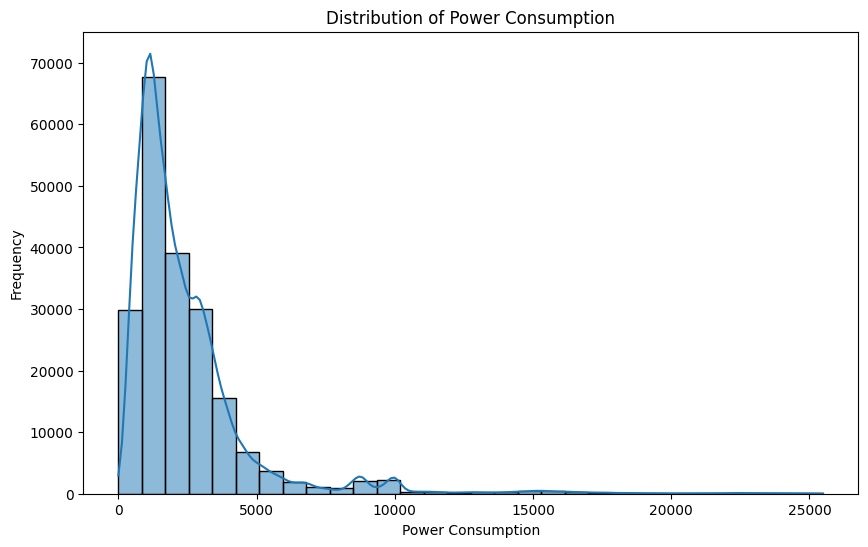

In [358]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(train['power_consumption'], bins=30, kde=True)
plt.title('Distribution of Power Consumption')
plt.xlabel('Power Consumption')
plt.ylabel('Frequency')
plt.show()

->skew된 분포를 보이므로 학습데이터에 한해서 로그변환 필요해보임

In [359]:
# 년기준 일 평균 소비전력
train['day_of_year'] = train['date_time'].dt.dayofyear
mean_power_by_day_of_year = train.groupby('day_of_year')['power_consumption'].mean()
# 년기준 시간평균 소비전력
train['hour_of_year'] = train['date_time'].dt.hour + (train['date_time'].dt.dayofyear - 1) * 24
mean_power_by_hour_of_year = train.groupby('hour_of_year')['power_consumption'].mean()

# 년기준 월평균 소비전력
mean_power_by_month = train.groupby('month')['power_consumption'].mean()

# 일기준 시간 평균 소비전력
mean_power_by_hour = train.groupby('hour')['power_consumption'].mean()

# 월기준 시간 평균 소비전력
mean_power_by_day = train.groupby('day')['power_consumption'].mean()

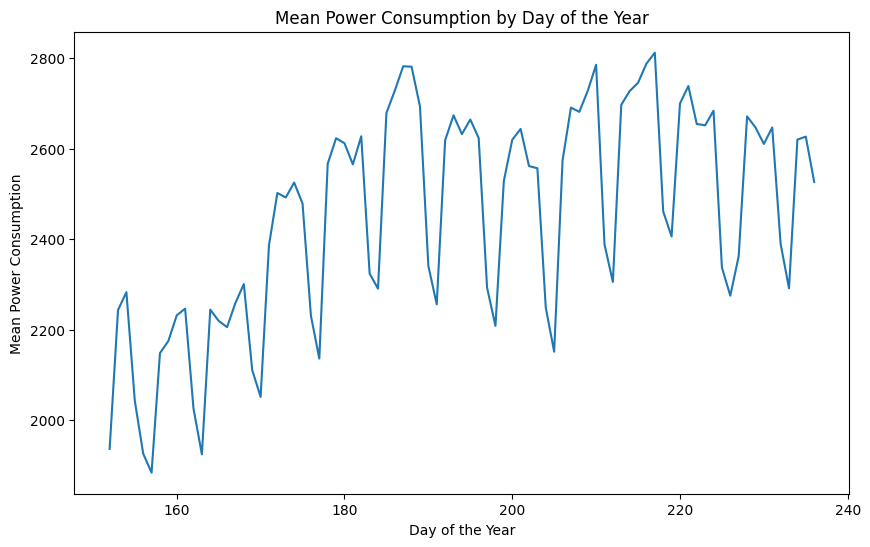

In [360]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_power_by_day_of_year.index, y=mean_power_by_day_of_year.values)
plt.title('Mean Power Consumption by Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Mean Power Consumption')
plt.show()

-> 8월로 갈수록 오르는 추세. 중간중간 떨어지는건 주말이라고 추론. 주말 혹은 요일 데이터를 파생변수로 추가 가능해보임

# 요일 별 전력 사용량 분포

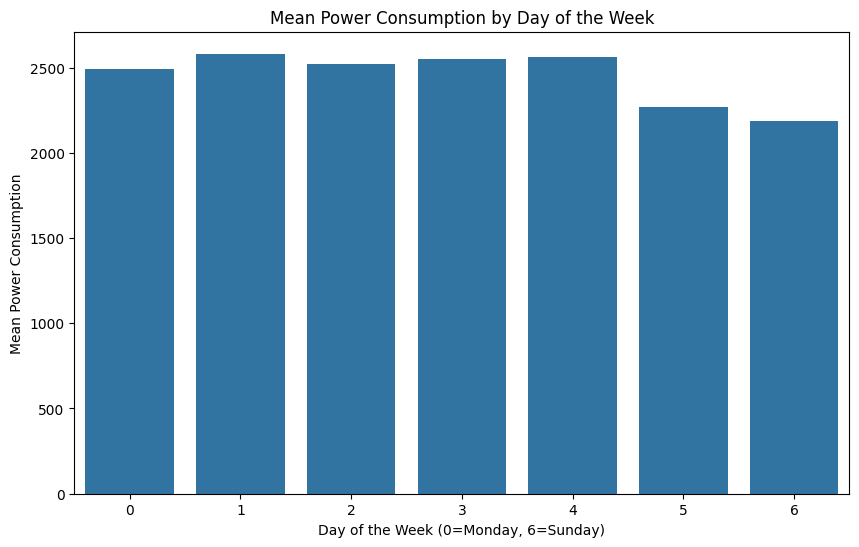

In [361]:
# 요일 파생변수 생성 0-월요일 6-일요일
train['day_of_week'] = train['date_time'].dt.dayofweek

# 요일별 전력평균
mean_power_by_day_of_week = train.groupby('day_of_week')['power_consumption'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_power_by_day_of_week.index, y=mean_power_by_day_of_week.values)
plt.title('Mean Power Consumption by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Mean Power Consumption')
plt.show()

-> 주말(5,6)에는 전력사용량 상대적으로 낮음. 따라서 요일데이터(day_of_week)를 파생변수로 추가함



In [362]:
#weekend(공휴일) 변수 생성
train['weekend'] = train.apply(lambda x : 0 if x['day_of_week']<5 else 1, axis = 1)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47568 (\N{HANGUL SYLLABLE MAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


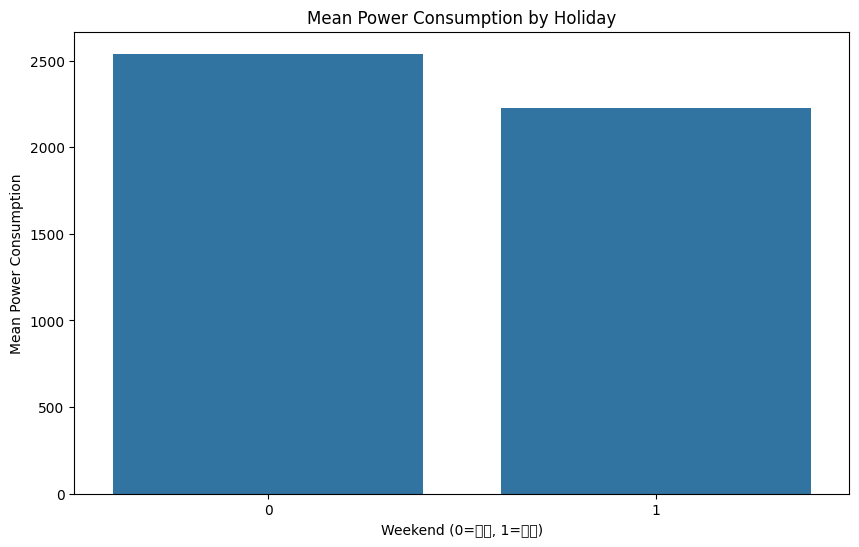

In [363]:
# 요일별 전력평균
mean_power_by_weekend = train.groupby('weekend')['power_consumption'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=mean_power_by_weekend.index, y=mean_power_by_weekend.values)
plt.title('Mean Power Consumption by Holiday')
plt.xlabel('Weekend (0=평일, 1=주말)')
plt.ylabel('Mean Power Consumption')
plt.show()

-> 공휴일(토,일)에는 상대적으로 전력사용량 적은것 확인. 따라서 공휴일(weekend)를 파생변수로 추가

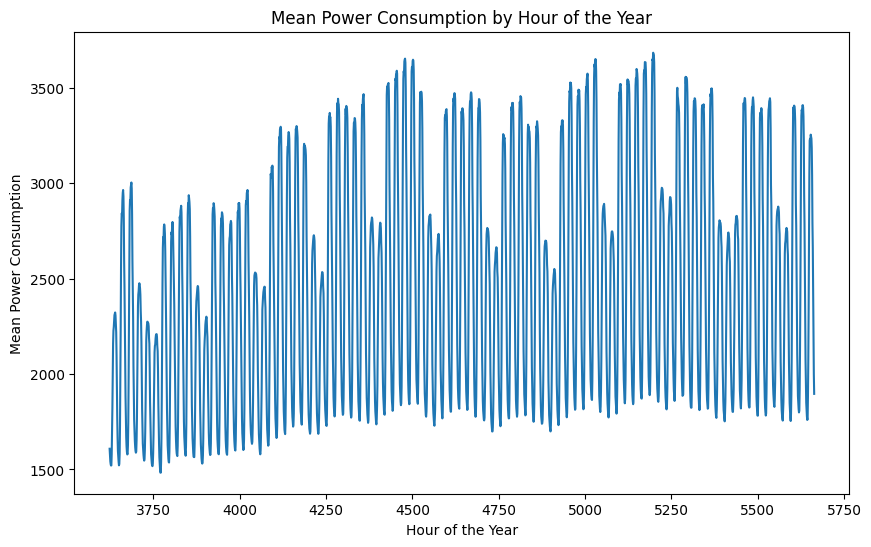

In [364]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_power_by_hour_of_year.index, y=mean_power_by_hour_of_year.values)
plt.title('Mean Power Consumption by Hour of the Year')
plt.xlabel('Hour of the Year')
plt.ylabel('Mean Power Consumption')
plt.show()

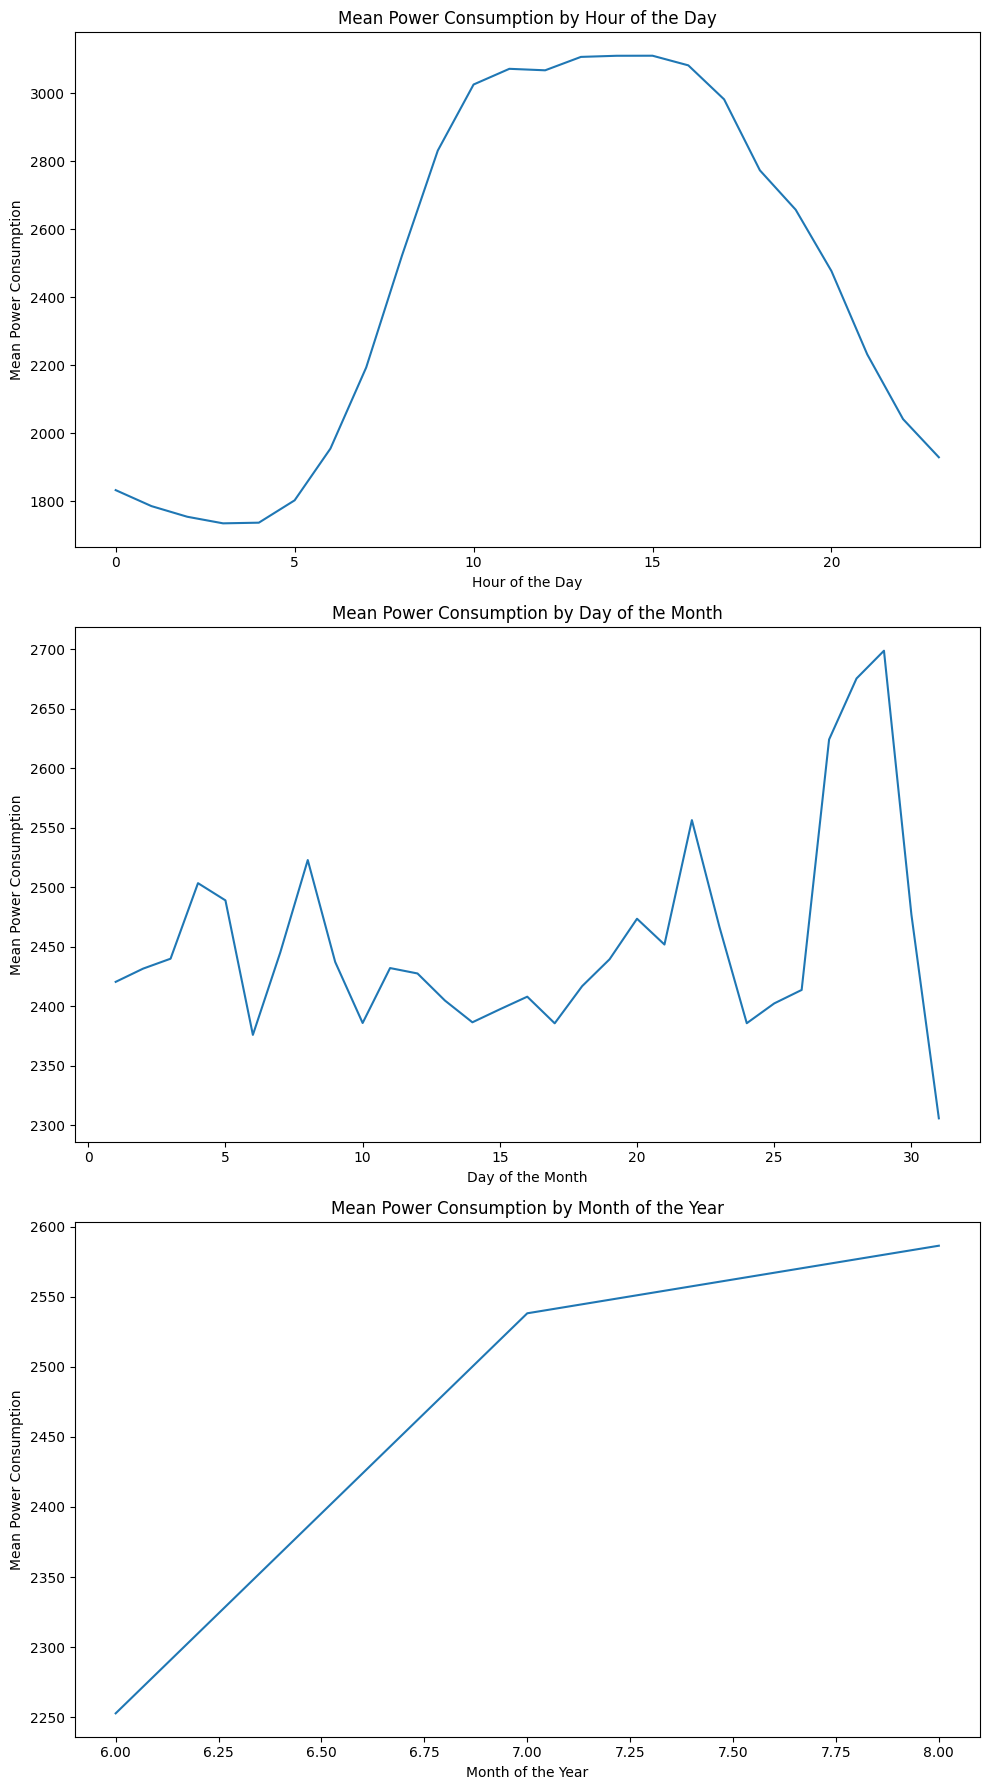

In [365]:
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot mean power consumption by hour of the day
sns.lineplot(x=mean_power_by_hour.index, y=mean_power_by_hour.values, ax=axs[0])
axs[0].set_title('Mean Power Consumption by Hour of the Day')
axs[0].set_xlabel('Hour of the Day')
axs[0].set_ylabel('Mean Power Consumption')

# Plot mean power consumption by day of the month
sns.lineplot(x=mean_power_by_day.index, y=mean_power_by_day.values, ax=axs[1])
axs[1].set_title('Mean Power Consumption by Day of the Month')
axs[1].set_xlabel('Day of the Month')
axs[1].set_ylabel('Mean Power Consumption')

# 년기준 월평균 소비전력
sns.lineplot(x=mean_power_by_month.index, y=mean_power_by_month.values, ax=axs[2])
axs[2].set_title('Mean Power Consumption by Month of the Year')
axs[2].set_xlabel('Month of the Year')
axs[2].set_ylabel('Mean Power Consumption')

plt.tight_layout()
plt.show()

-> 낮시간에 사용량 많고, 밤시간대에는 전력사용량 증가(낮에 근무), 8월에 가까워질수록 전력 사용량 증가(더워질수록 에어컨 사용량 증가)

building type 별 전력사용량 분포

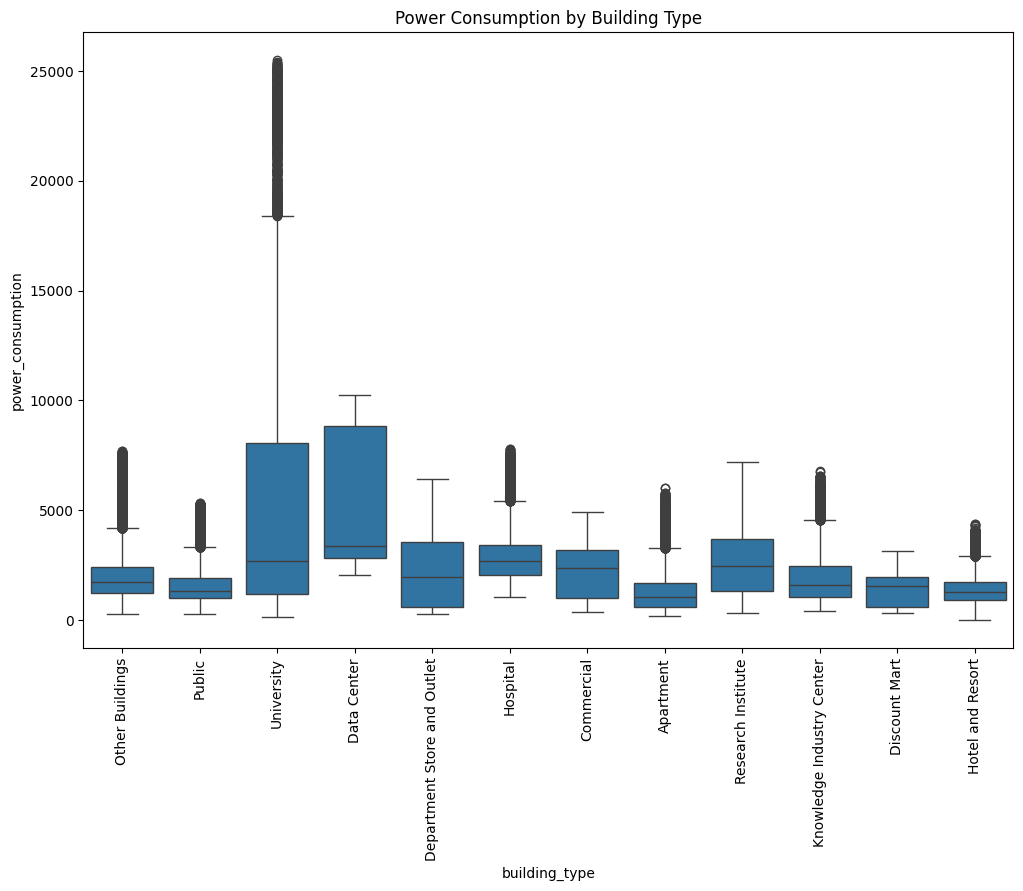

In [366]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='building_type', y='power_consumption', data=train)
plt.title('Power Consumption by Building Type')
plt.xticks(rotation=90)
plt.show()

건물 별 전력사용량 각각을 봐도 전체 전력사용량 데이터에서처럼 skewed되어있으면서 분포가 전부 다름.

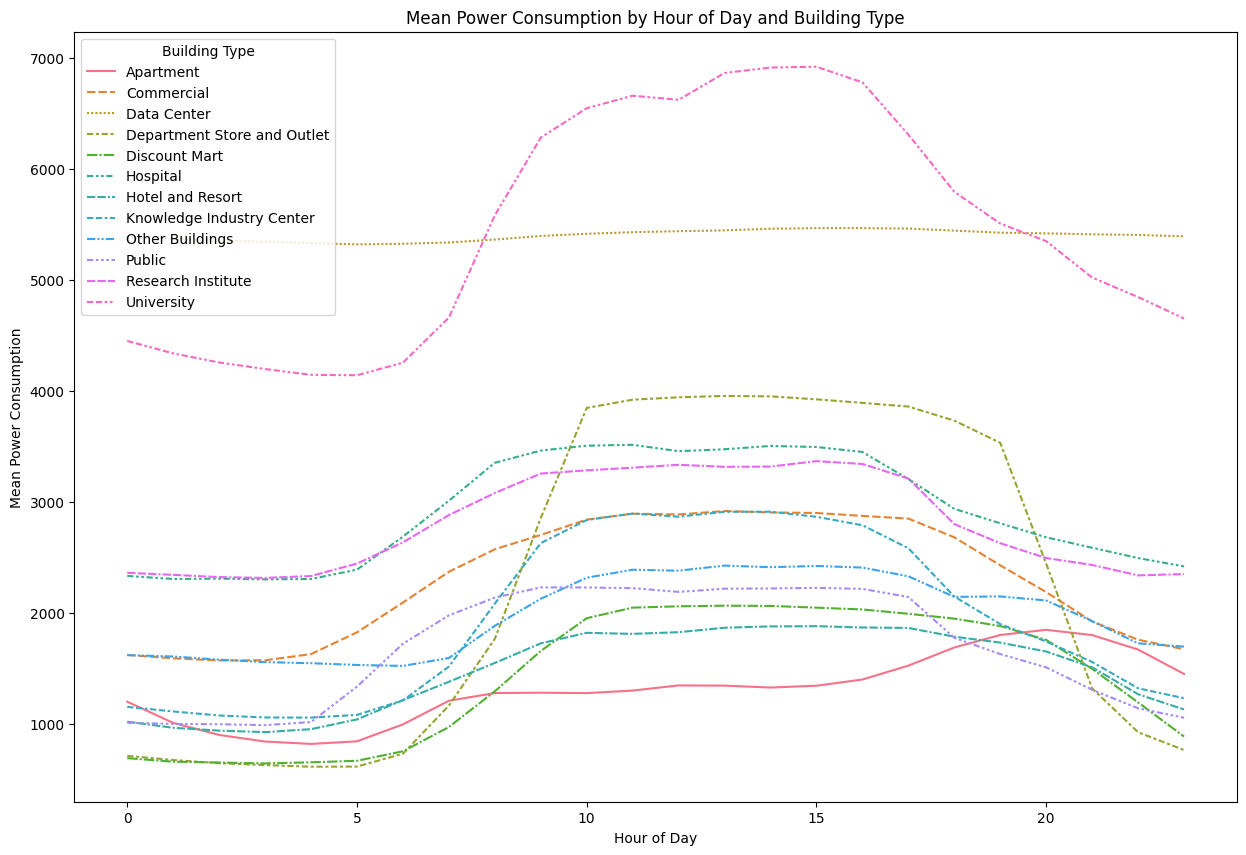

In [367]:
mean_power_by_hour_building = train.groupby(['hour', 'building_type'])['power_consumption'].mean().reset_index()

pivot_df = mean_power_by_hour_building.pivot(index='hour', columns='building_type', values='power_consumption')

plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df)
plt.title('Mean Power Consumption by Hour of Day and Building Type')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

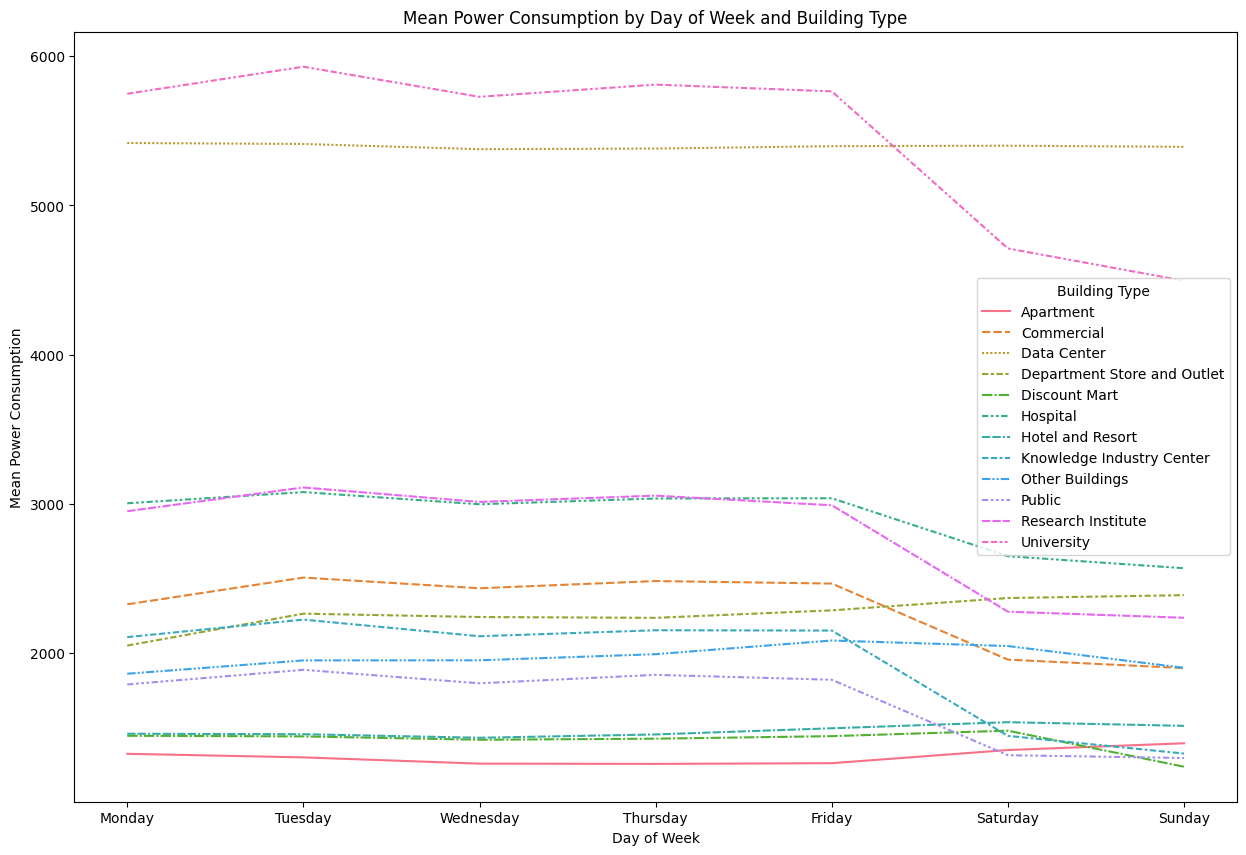

In [368]:
mean_power_by_day_building = train.groupby(['day_of_week', 'building_type'])['power_consumption'].mean().reset_index()

pivot_df_day = mean_power_by_day_building.pivot(index='day_of_week', columns='building_type', values='power_consumption')

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df_day.index = day_names

plt.figure(figsize=(15, 10))
sns.lineplot(data=pivot_df_day)
plt.title('Mean Power Consumption by Day of Week and Building Type')
plt.xlabel('Day of Week')
plt.ylabel('Mean Power Consumption')
plt.legend(title='Building Type')
plt.show()

datacenter의 경우 요일 평균과, 시간 평균 모두 일정한 모습을 보임

data center와 university에서 아주 많은 양의 전력을 소모.



대부분 낮시간에 전력을 많이 소모하지만 datacenter와 Apartment는 다른 양상을 띈다.


또한 주말에는 전력 소비가 대체로 낮아지지만 상가나 아파트는 오히려 증가하는 모습을 보인다.

따라서 building_type별 다른 모델링을 하는방법 고려

# building_type 범주형 라벨 인코딩

In [369]:
conv_dict = dict(zip(list(train['building_type'].unique()), [0,1,2,3,4,5,6,7,8,9,10,11]))
conv_dict

{'Other Buildings': 0,
 'Public': 1,
 'University': 2,
 'Data Center': 3,
 'Department Store and Outlet': 4,
 'Hospital': 5,
 'Commercial': 6,
 'Apartment': 7,
 'Research Institute': 8,
 'Knowledge Industry Center': 9,
 'Discount Mart': 10,
 'Hotel and Resort': 11}

In [370]:
train['building_type'] = train['building_type'].map(conv_dict)

In [371]:
train.head()

,building_number,date_time,temperature,rainfall,windspeed,humidity,power_consumption,building_type,total_area,cooling_area,...,ess_capacity,pcs_capacity,hour,day,month,year,day_of_year,hour_of_year,day_of_week,weekend
0,1,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,1085.28,0,110634.0,39570.0,...,0.0,0.0,0,1,6,2022,152,3624,2,0
1,1,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,1047.36,0,110634.0,39570.0,...,0.0,0.0,1,1,6,2022,152,3625,2,0
2,1,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,974.88,0,110634.0,39570.0,...,0.0,0.0,2,1,6,2022,152,3626,2,0
3,1,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,953.76,0,110634.0,39570.0,...,0.0,0.0,3,1,6,2022,152,3627,2,0
4,1,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,986.40,0,110634.0,39570.0,...,0.0,0.0,4,1,6,2022,152,3628,2,0


# 생각나는 파생변수 추가(THI,WCT,CDH)

분석 데이터가 여름철 데이터인 만큼 전력 사용량과 관련이 있을 것이라고 판단하여 불쾌지수(THI) 변수를 추가함

In [372]:
train['THI'] = 9/5*train['temperature'] - 0.55*(1-train['humidity']/100)*(9/5*train['humidity']-26)+32

체감온도(WCT)는 기온과 풍속의 조합으로 사람이 체감적으로 느끼는 온도. 분석 데이터에 기온과 풍속 변수가 모두 있기 때문에 계산을 통해 구할 수 있음.

불쾌지수에서 포함하지 않은 바람의 조건을 포함하고 있어 불쾌지수를 보완해주는 변수라고 판단해 추가

In [373]:
train['WCT'] = 13.12 + 0.6125*train['temperature'] - 11.37*(train['windspeed']**
                                                            0.16) + 0.3965*(train['windspeed']**0.16)*train['temperature']

냉방도일(CDH)는 냉방을 위한 필요 에너지를 산정하는 데 쓰는 변수. 여름철 데이터를 분석하는 것이기 때문에 냉방을 위한 전력 소모가 많을 것으로 예상되어 해당 변수를 추가했음

In [374]:
def CDH(xs):
    cumsum = np.cumsum(xs - 26)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    cdhs = []
    for i in range(1, 101):
        temp = dataframe[dataframe['building_number'] == i]['temperature'].values
        cdh = CDH(temp)
        cdhs.append(cdh)
    return np.concatenate(cdhs)

train['CDH'] = calculate_and_add_cdh(train)

In [375]:
train['power_consumption']

0         1085.28
1         1047.36
2          974.88
3          953.76
4          986.40
           ...   
203995     881.04
203996     798.96
203997     825.12
203998     640.08
203999     540.24
Name: power_consumption, Length: 204000, dtype: float64

# 학습진행

먼저 단일모델 학습진행

In [376]:
train.columns

Index(['building_number', 'date_time', 'temperature', 'rainfall', 'windspeed',
       'humidity', 'power_consumption', 'building_type', 'total_area',
       'cooling_area', 'solar_power_capacity', 'ess_capacity', 'pcs_capacity',
       'hour', 'day', 'month', 'year', 'day_of_year', 'hour_of_year',
       'day_of_week', 'weekend', 'THI', 'WCT', 'CDH'],
      dtype='object')

In [377]:
# building_number,date_time은 필요없는 변수, day_of_week는 weekend(공휴일)변수가 있으므로 weekend만 포함,year는 2022데이터만 있기때문에 제거
train = train.drop(columns=['building_number','date_time', 'day_of_week','year'])

In [378]:
# 일단 이 변수들로 학습진행
train.columns

Index(['temperature', 'rainfall', 'windspeed', 'humidity', 'power_consumption',
       'building_type', 'total_area', 'cooling_area', 'solar_power_capacity',
       'ess_capacity', 'pcs_capacity', 'hour', 'day', 'month', 'day_of_year',
       'hour_of_year', 'weekend', 'THI', 'WCT', 'CDH'],
      dtype='object')

In [379]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [380]:
# 모델 성능지표정의 SMAPE : Symmetric Mean Absolute Percentage Error
# MAPE의 경우 Actual 값이 0이거나 작은 경우 MAPE 값이 지나치게 커지는 문제가 있음
# SMAPE는 이를 개선한 성능지표임

def SMAPE(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [381]:
# 특성과 라벨 분리
X_train = train.drop(columns=['power_consumption'])
y_train = train['power_consumption']
# 데이터 분할 (훈련 및 검증 세트)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_all = XGBRegressor(random_state=42)
# 모델 학습
model_all.fit(X_train_all, y_train_all)
pred = model_all.predict(X_test_all)

In [382]:
smape_all=SMAPE(y_test_all, pred)
smape_all

10.006574764320256

# 하이퍼파라미터 튜닝

해봤는데 성능향상 별로 없어서 일단 생략

In [385]:
# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [5000],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.5,0.7, 0.9],
}

In [386]:
# 그리드 서치 객체 생성
grid_search = GridSearchCV(estimator=model_all, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_percentage_error')

In [387]:
# 그리드 서치 수행. 30분 정도 걸림
# grid_search.fit(X_train_all, y_train_all, eval_set=[(X_test_all, y_test_all)], early_stopping_rounds=10, verbose=True)

In [388]:
# 최적의 하이퍼파라미터 출력
# print("Best Hyperparameters:", grid_search.best_params_)

In [389]:
# 테스트 세트에서 최적 모델의 성능 평가
#y_test_pred_best = grid_search.best_estimator_.predict(X_test_all)
#test_rmse_best = np.sqrt(mean_squared_error(y_test_all, y_test_pred_best))
#print("Validation RMSE with Best Model:", test_rmse_best)

In [390]:
# 단일모델에서 최적의 하이퍼파라미터 저장
# best_param_all={'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 5000, 'subsample': 0.9}
# 생각보다 성능향상 일어나지 않음

# building_type 별 모델링

In [391]:
train['building_type']

0          0
1          0
2          0
3          0
4          0
          ..
203995    11
203996    11
203997    11
203998    11
203999    11
Name: building_type, Length: 204000, dtype: int64

In [392]:
type_list = []
for value in train.building_type.values:
    if value not in type_list:
        type_list.append(value)

In [393]:
# 0, 1, 2, ,,, 11 총 12개 모델링 해야함
type_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [394]:
train_building0 = train[train['building_type']==0]
train_building1 = train[train['building_type']==1]
train_building2 = train[train['building_type']==2]
train_building3 = train[train['building_type']==3]
train_building4 = train[train['building_type']==4]
train_building5 = train[train['building_type']==5]
train_building6 = train[train['building_type']==6]
train_building7 = train[train['building_type']==7]
train_building8 = train[train['building_type']==8]
train_building9 = train[train['building_type']==9]
train_building10 = train[train['building_type']==10]
train_building11 = train[train['building_type']==11]

In [395]:
# 데이터 다시 불러오기
train = pd.read_csv("/content/drive/MyDrive/전력사용량예측/train.csv",encoding='cp949')

In [396]:
train.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

In [397]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})

In [398]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [399]:
train = train.drop(columns=['sunshine', 'solar_radiation'])
train = pd.merge(train, building_info, on='building_number', how='left')
train['building_type'] = train['building_type'].map(conv_dict)
y_train=train[['building_type','power_consumption']]

건물 타입별 모델링

In [400]:
smape_building_type = []

In [401]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train0 = X_train[(X_train.building_type == 0)]
y_train0 = y_train[(y_train.building_type == 0)]
# 데이터 분할 (훈련 및 검증 세트)
X_train0, X_test0, y_train0, y_test0 = train_test_split(X_train0, y_train0, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_0 = XGBRegressor(random_state=42)
# 모델 학습
model_0.fit(X_train0, y_train0)
# 성능 출력
pred0 = model_0.predict(X_test0)
smape0 = SMAPE(y_test0, pred0)
smape_building_type.append(smape0)

In [402]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train1 = X_train[(X_train.building_type == 1)]
y_train1 = y_train[(y_train.building_type == 1)]
# 데이터 분할 (훈련 및 검증 세트)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_1 = XGBRegressor(random_state=42)
# 모델 학습
model_1.fit(X_train1, y_train1)
# 성능출력
pred1 = model_1.predict(X_test1)
smape1 = SMAPE(y_test1, pred1)
smape_building_type.append(smape1)

In [403]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train2 = X_train[(X_train.building_type == 2)]
y_train2 = y_train[(y_train.building_type == 2)]
# 데이터 분할 (훈련 및 검증 세트)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train2, y_train2, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_2 = XGBRegressor(random_state=42)
# 모델 학습
model_2.fit(X_train2, y_train2)
# 성능출력
pred2 = model_2.predict(X_test2)
smape2 = SMAPE(y_test2, pred2)
smape_building_type.append(smape2)

In [404]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train3 = X_train[(X_train.building_type == 3)]
y_train3 = y_train[(y_train.building_type == 3)]
# 데이터 분할 (훈련 및 검증 세트)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_train3, y_train3, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_3 = XGBRegressor(random_state=42)
# 모델 학습
model_3.fit(X_train3, y_train3)
# 성능출력
pred3 = model_3.predict(X_test3)
smape3 = SMAPE(y_test3, pred3)
smape_building_type.append(smape3)

In [405]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train4 = X_train[(X_train.building_type == 4)]
y_train4 = y_train[(y_train.building_type == 4)]
# 데이터 분할 (훈련 및 검증 세트)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X_train4, y_train4, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_4 = XGBRegressor(random_state=42)
# 모델 학습
model_4.fit(X_train4, y_train4)
# 성능출력
pred4 = model_4.predict(X_test4)
smape4 = SMAPE(y_test4, pred4)
smape_building_type.append(smape4)

In [406]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train6 = X_train[(X_train.building_type == 5)]
y_train5 = y_train[(y_train.building_type == 5)]
# 데이터 분할 (훈련 및 검증 세트)
X_train6, X_test5, y_train5, y_test5 = train_test_split(X_train6, y_train5, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_5 = XGBRegressor(random_state=42)
# 모델 학습
model_5.fit(X_train6, y_train5)
# 성능출력
pred5 = model_5.predict(X_test5)
smape5 = SMAPE(y_test5, pred5)
smape_building_type.append(smape5)

In [407]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train6 = X_train[(X_train.building_type == 6)]
y_train6 = y_train[(y_train.building_type == 6)]
# 데이터 분할 (훈련 및 검증 세트)
X_train6, X_test6, y_train6, y_test6 = train_test_split(X_train6, y_train6, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_6 = XGBRegressor(random_state=42)
# 모델 학습
model_6.fit(X_train6, y_train6)
# 성능출력
pred6 = model_6.predict(X_test6)
smape6 = SMAPE(y_test6, pred6)
smape_building_type.append(smape6)

In [408]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train7 = X_train[(X_train.building_type == 7)]
y_train7 = y_train[(y_train.building_type == 7)]
# 데이터 분할 (훈련 및 검증 세트)
X_train7, X_test7, y_train7, y_test7 = train_test_split(X_train7, y_train7, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_7 = XGBRegressor(random_state=42)
# 모델 학습
model_7.fit(X_train7, y_train7)
# 성능출력
pred7 = model_7.predict(X_test7)
smape7 = SMAPE(y_test7, pred7)
smape_building_type.append(smape7)

In [409]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train8= X_train[(X_train.building_type == 8)]
y_train8 = y_train[(y_train.building_type == 8)]
# 데이터 분할 (훈련 및 검증 세트)
X_train8, X_test8, y_train8, y_test8 = train_test_split(X_train8, y_train8, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_8 = XGBRegressor(random_state=42)
# 모델 학습
model_8.fit(X_train8, y_train8)
# 성능출력
pred8 = model_8.predict(X_test8)
smape8 = SMAPE(y_test8, pred8)
smape_building_type.append(smape8)

In [410]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train9= X_train[(X_train.building_type == 9)]
y_train9 = y_train[(y_train.building_type == 9)]
# 데이터 분할 (훈련 및 검증 세트)
X_train9, X_test9, y_train9, y_test9 = train_test_split(X_train9, y_train9, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_9 = XGBRegressor(random_state=42)
# 모델 학습
model_9.fit(X_train9, y_train9)
# 성능출력
pred9 = model_9.predict(X_test9)
smape9 = SMAPE(y_test9, pred9)
smape_building_type.append(smape9)

In [411]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train10= X_train[(X_train.building_type == 10)]
y_train10 = y_train[(y_train.building_type == 10)]
# 데이터 분할 (훈련 및 검증 세트)
X_train10, X_test10, y_train10, y_test10 = train_test_split(X_train10, y_train10, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_10 = XGBRegressor(random_state=42)
# 모델 학습
model_10.fit(X_train10, y_train10)
# 성능출력
pred10 = model_10.predict(X_test10)
smape10 = SMAPE(y_test10, pred10)
smape_building_type.append(smape10)

In [412]:
# 특성과 라벨 분리 - 이거 하려고 데이터 다시 불러온거임
X_train11= X_train[(X_train.building_type == 11)]
y_train11 = y_train[(y_train.building_type == 11)]
# 데이터 분할 (훈련 및 검증 세트)
X_train11, X_test11, y_train11, y_test11 = train_test_split(X_train11, y_train11, test_size=0.2, random_state=42)
# XGBoost 모델 생성
model_11 = XGBRegressor(random_state=42)
# 모델 학습
model_11.fit(X_train11, y_train11)
# 성능출력
pred11 = model_11.predict(X_test11)
smape11 = SMAPE(y_test11, pred11)
smape_building_type.append(smape11)

In [413]:
smape_building_type

[103.91973690134944,
 2.6051387079221984,
 2.0600545139749715,
 0.16446899395040002,
 3.4299909015923764,
 1.4091991055078417,
 3.3901217949099247,
 2.285804453939465,
 2.1299959030591205,
 2.129549400543157,
 2.9314911755525537,
 3.0717392070362095]

In [414]:
smape_all

10.006574764320256

빌딩 타입별 모델링 결과(smape_building_type)가 한번에 모델링(smape_all) 결과보다 0='other buildings'를 제외하면 확실히 좋다.